In [1]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time
from model import make_model

import config


np.set_printoptions(precision=4, suppress = True)

Using TensorFlow backend.


In [2]:
def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma

def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np.random.randn(*log_sigma.shape) 
    return z


def get_z_from_rnn_output(y_pred):
    HIDDEN_UNITS = 256
    GAUSSIAN_MIXTURES = 5
    Z_DIM = 32
    d = GAUSSIAN_MIXTURES * Z_DIM

    z_pred = y_pred[:(3*d)]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_log_pi = np.zeros(Z_DIM)
    chosen_mu = np.zeros(Z_DIM)
    chosen_log_sigma = np.zeros(Z_DIM)

    # adjust temperatures
    logmix2 = np.copy(log_pi)
    logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(Z_DIM, 1)


    for j in range(Z_DIM):
        idx = get_pi_idx(np.random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j, idx]
        chosen_log_sigma[j] = log_sigma[j,idx]

    next_z = sample_z(chosen_mu, chosen_log_sigma)

    # print(next_z)
    # print(rew_pred)
    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0
        
    return next_z, next_reward, chosen_mu

In [3]:
model = make_model()
model.make_env('car_racing')

In [4]:
model.load_model('./controller/car_racing.cma.4.12.best.json125')

loading file ./controller/car_racing.cma.4.12.best.json125


In [5]:
z_weight = model.weight[0][:32,2]
h_weight = model.weight[0][32:,2]

In [6]:
z_weight

array([ 0.0889, -0.8851,  0.4943,  0.9015, -0.0661,  0.4676, -0.4397,
       -0.6314,  0.933 ,  0.1831,  0.5784, -0.5514, -0.0216,  0.2701,
        0.3181,  0.5784, -0.6277, -0.21  ,  0.2918,  0.7946,  0.2159,
       -0.6404, -0.7126,  0.3232,  0.135 , -0.183 , -0.3667,  0.3491,
        0.5804,  0.9754,  0.6231, -0.38  ])

In [7]:
h_weight

array([ 0.0671, -0.0496,  0.7935, -0.3483,  0.5658, -0.7423,  0.0274,
        0.6239, -0.1438, -0.823 ,  0.0786, -0.0584,  0.1492, -0.428 ,
       -0.8192,  0.3237, -0.5152, -0.1221, -0.9435, -0.3296, -0.3302,
       -0.4333, -1.3902, -0.5344,  0.4736, -0.2117, -0.5429,  0.657 ,
        2.237 , -1.0796,  0.0612,  0.4551,  0.0522,  0.5383, -1.2528,
       -0.0576, -0.6916,  0.7051,  0.3191,  0.2177, -0.9006,  1.096 ,
       -0.7571,  0.45  ,  0.143 , -0.41  ,  0.3675, -1.0409,  0.8376,
       -0.1021,  0.8515,  0.7997,  0.7492,  0.1155,  0.4803, -0.0591,
       -0.0291, -0.3584, -0.678 , -0.0811, -1.0352,  0.2375, -1.0032,
        0.5743,  0.2797, -1.4168,  1.3076, -0.1322,  0.235 ,  0.0532,
        1.1113, -0.3893, -0.1278,  0.5242,  0.4399,  0.1248, -0.5886,
       -0.026 , -0.6912,  0.1948, -0.2013, -0.8763,  1.0371,  0.5878,
       -0.4661,  1.1388, -0.2149, -0.6456,  0.0331,  0.907 , -0.3712,
        0.052 , -0.0412,  0.1184, -0.2248, -0.2423,  0.0394, -0.333 ,
        0.0387,  0.0

In [8]:
rollout_files = np.load('./data/rollout/23394598.npz') 
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load('./data/series/23008920.npz') 
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']


In [9]:
obs = obs_file[0]
action = [0,0,0]
reward = 0
model.reset()

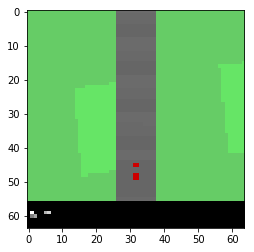

In [10]:
plt.imshow(obs)

In [11]:
vae_encoded_obs = model.update(obs, 0)

In [12]:
vae_encoded_obs

array([-0.8623, -0.8155,  0.1048, -0.947 ,  1.1862,  0.2677,  0.2953,
        0.5872,  0.0701,  2.2902,  0.7728,  0.9659,  0.6605,  0.165 ,
        0.7599, -0.3551, -0.9889, -0.2443, -1.1726, -0.8551,  2.0534,
       -0.2162,  0.9544, -1.3567, -0.1726,  0.9121, -2.0627, -1.1991,
       -0.7927, -1.3719, -0.9942, -0.4316], dtype=float32)

In [13]:
recon = model.vae.decoder.predict(np.array([vae_encoded_obs]))[0]

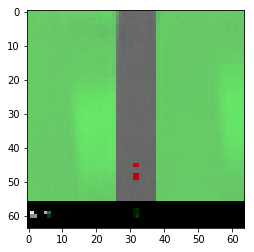

In [14]:
plt.imshow(recon)

In [15]:
# obs = obs_file[0]
action = [0,1,0]
reward = 0
model.reset()
total_reward = 0
total_pseudo_reward = 0
t = 0

obs = model.env.reset()

model.env.render('rgb_array')

actions0 = []
actions1 = []
actions2 = []

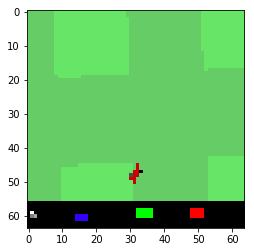

611.912658227833
230
1190
[-0.9832  1.      0.0004]


KeyboardInterrupt: 

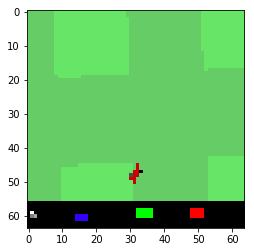

In [16]:
while (1):
   
    ######

    obs = config.adjust_obs(obs)
    reward = config.adjust_reward(reward)
    
    total_pseudo_reward+= reward

    vae_encoded_obs = model.update(obs, 0)

    recon = model.vae.decoder.predict(np.array([vae_encoded_obs]))[0]
    
#     input_to_rnn = [np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]),np.zeros(shape=(1,256)),np.zeros(shape=(1,256))]
#     input_to_rnn = [np.array([[np.concatenate([np.zeros(32), action, [reward]])]]),np.array([model.hidden]),np.array([model.cell_values])]


    input_to_rnn = [np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]),np.array([model.hidden]),np.array([model.cell_values])]

    #     print(np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]).shape)
    #     print(np.array([model.hidden]).shape)
    #     print(np.array([model.cell_values]).shape)

    out = model.rnn.forward.predict(input_to_rnn)

    y_pred = out[0][0][0]
    h = out[1][0]
    c = out[2][0]

    model.hidden = h
    model.cell_values = c

    next_z, next_reward, chosen_mu = get_z_from_rnn_output(y_pred)

    recon_next_z = model.vae.decoder.predict(np.array([next_z]))[0]

    controller_obs = np.concatenate([vae_encoded_obs,model.hidden])
    action = model.get_action(controller_obs, t=0, add_noise=0)
    #     actions0.append(action[0])
    #     actions1.append(action[1])
    #     actions2.append(action[2])

    #     action = model.activations(action)
#     action = [1,1,0]
    obs, reward, done, _ = model.env.step(action)
    
    total_reward+= reward


    plt.gca().cla() 
    plt.imshow( obs)

    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    
    print(total_reward)
    print(total_pseudo_reward)
    print(t)
    print(action)
    t += 1


    #     print(action)

In [17]:
print(controller_obs)

[ 0.8828 -0.4782 -0.4296  1.2763  0.1383 -1.9349 -0.5616 -0.8907  1.4824
 -0.7008 -0.1686  0.3619 -0.5266  0.1795 -0.433   0.2239  1.5414 -1.1811
 -0.6485 -0.4002 -1.4639 -0.5649  1.2551 -0.479   1.0175 -0.0756 -0.0032
 -1.5256  0.1553  0.6366 -0.923   0.5755  0.4016 -0.2257 -0.0307 -0.199
 -0.4602  0.7989  0.3597 -0.3055 -0.0909 -0.3194  0.3349  0.5282 -0.4594
 -0.528  -0.4609  0.6389 -0.4908 -0.4653  0.13    0.046  -0.0152  0.0879
  0.4261  0.1354  0.1422 -0.3847 -0.224  -0.2174 -0.4784  0.6094 -0.2175
  0.5221 -0.7423  0.0124 -0.4075 -0.095   0.4202  0.4558  0.052  -0.3109
  0.0675  0.8891 -0.1235  0.6537  0.3593  0.1624  0.0354 -0.578   0.3223
  0.2713 -0.3364 -0.3252 -0.3788  0.3623 -0.0722  0.4316  0.8078  0.6124
 -0.3104  0.3536  0.4791 -0.3628 -0.2487  0.0165 -0.2596 -0.6375 -0.0678
  0.2212 -0.1237  0.3834 -0.2706  0.3582  0.2367 -0.0771 -0.0335 -0.159
  0.0062 -0.477  -0.4096  0.1154  0.3224 -0.1087 -0.3247  0.0905  0.0348
  0.3322  0.3692  0.0083 -0.1193 -0.3824 -0.7829  0.3

In [18]:
print(model.hidden)

[ 0.3673 -0.2173 -0.0347 -0.192  -0.4902  0.7591  0.4209 -0.3449 -0.1144
 -0.2961  0.3294  0.5132 -0.4303 -0.5108 -0.4039  0.6775 -0.456  -0.4136
  0.1416  0.0411 -0.0333  0.1444  0.3445  0.0961 -0.0622 -0.4031 -0.1458
 -0.1986 -0.4445  0.5447 -0.2029  0.5505 -0.7194 -0.0168 -0.4268 -0.1077
  0.38    0.5141  0.1068 -0.31    0.0525  0.8694 -0.0974  0.6191  0.431
  0.262   0.04   -0.5667  0.3717  0.2964 -0.3211 -0.2846 -0.508   0.3991
 -0.1074  0.4427  0.8137  0.6052 -0.2351  0.3861  0.411  -0.3155 -0.3105
 -0.077  -0.3127 -0.648  -0.0423  0.1353 -0.0916  0.4302 -0.2465  0.3743
  0.235  -0.1636 -0.2471 -0.2186  0.5172 -0.4032 -0.3727  0.1389  0.3427
  0.0142 -0.3275  0.0453  0.0366  0.3289  0.3926 -0.0017 -0.0093 -0.3894
 -0.7768 -0.0353  0.142  -0.6526  0.2089  0.4534  0.3585  0.7039 -0.9796
  0.3503  0.4689  0.2849 -0.3771  0.3936 -0.4705 -0.0711  0.3521  0.3256
 -0.3854 -0.5693  0.549  -0.3924 -0.7024 -0.2901  0.4616 -0.1069  0.0276
 -0.2458  0.5486 -0.3024  0.0716  0.3739  0.3432  0.

In [19]:
actions0

[]

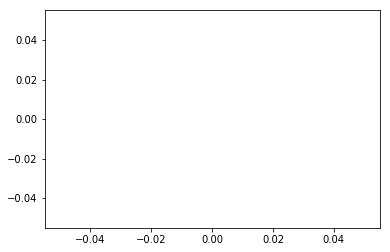

In [20]:
plt.plot(actions0)
plt.plot(actions1)
plt.plot(actions2)

In [21]:
model.hidden[:10]

#######

array([ 0.3673, -0.2173, -0.0347, -0.192 , -0.4902,  0.7591,  0.4209,
       -0.3449, -0.1144, -0.2961], dtype=float32)

In [22]:
vae_encoded_obs

array([ 1.4713,  0.8197, -0.0574,  0.5902, -0.1375, -1.5853, -1.0767,
        0.1153, -1.1589,  2.243 ,  2.1072, -0.4164,  0.6787, -2.1312,
       -0.4161, -0.1348,  0.4867, -1.8644, -0.0855,  0.2217, -1.3514,
       -0.6412,  0.2439, -0.2959,  0.5843, -0.3682, -0.211 , -1.2974,
       -0.358 ,  1.8151, -1.0622, -0.0549], dtype=float32)

In [23]:
controller_obs

array([ 0.8828, -0.4782, -0.4296,  1.2763,  0.1383, -1.9349, -0.5616,
       -0.8907,  1.4824, -0.7008, -0.1686,  0.3619, -0.5266,  0.1795,
       -0.433 ,  0.2239,  1.5414, -1.1811, -0.6485, -0.4002, -1.4639,
       -0.5649,  1.2551, -0.479 ,  1.0175, -0.0756, -0.0032, -1.5256,
        0.1553,  0.6366, -0.923 ,  0.5755,  0.4016, -0.2257, -0.0307,
       -0.199 , -0.4602,  0.7989,  0.3597, -0.3055, -0.0909, -0.3194,
        0.3349,  0.5282, -0.4594, -0.528 , -0.4609,  0.6389, -0.4908,
       -0.4653,  0.13  ,  0.046 , -0.0152,  0.0879,  0.4261,  0.1354,
        0.1422, -0.3847, -0.224 , -0.2174, -0.4784,  0.6094, -0.2175,
        0.5221, -0.7423,  0.0124, -0.4075, -0.095 ,  0.4202,  0.4558,
        0.052 , -0.3109,  0.0675,  0.8891, -0.1235,  0.6537,  0.3593,
        0.1624,  0.0354, -0.578 ,  0.3223,  0.2713, -0.3364, -0.3252,
       -0.3788,  0.3623, -0.0722,  0.4316,  0.8078,  0.6124, -0.3104,
        0.3536,  0.4791, -0.3628, -0.2487,  0.0165, -0.2596, -0.6375,
       -0.0678,  0.2

In [24]:
action

array([-0.9832,  1.    ,  0.0004])